In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from matplotlib.animation import FuncAnimation
from pyDOE import lhs

### Mandelbrot functions

In [13]:
# mandelbrot algorithm
@jit(nopython=True)
def mandelbroth(real, imaginary, max_iter):

    c = complex(real, imaginary)
    z = 0.0j
    
    for i in range(max_iter):
        z = z * z + c
        if np.abs(z) >= 2:
            return i
        
    return max_iter

# run multiple iterations of algorithm
@jit(nopython=True)
def mandelbrot_set(real, imaginary, max_iter=100):

    mandelbrot = np.zeros((len(real), len(imaginary)), dtype=np.int64)

    for i in range(len(real)):
        # if i % 100 == 0:
        #     print(f"i={i}")
        for j in range(len(imaginary)):
            mandelbrot[i, j] = mandelbroth(real[i], imaginary[j], max_iter)

    return mandelbrot


### Animation functions

In [ ]:
def find_edge_coordinates(mandelbrot_set):
    
    edge_coords = np.argwhere(mandelbrot_set[:-1, :-1] != mandelbrot_set[1:, 1:])
    return edge_coords

# realign animation to follow edge of mandelbrot
def update(frame):
    global real_values, imaginary_values
    if frame % 50 == 0:
        print(f"current frame: {frame}")
    mandelbrot = mandelbrot_set(real_values, imaginary_values, max_iter=500)
    edge_coords = find_edge_coordinates(mandelbrot)

    if len(edge_coords) == 0:
        return

    edge_x, edge_y = np.mean(edge_coords, axis=0)
    
    center_real = real_values[int(edge_x)]
    center_imag = imaginary_values[int(edge_y)]

    zoom_factor = 0.95

    real_values = real_values * zoom_factor + (1 - zoom_factor) * center_real
    imaginary_values = imaginary_values * zoom_factor + (1 - zoom_factor) * center_imag

    # Recalculate Mandelbrot set and update plot
    mandelbrot = mandelbrot_set(real_values, imaginary_values)
    im.set_array(mandelbrot.T)
    im.set_extent([real_values[0], real_values[-1], imaginary_values[0], imaginary_values[-1]])

    return [im]

### Sampling functions

In [ ]:
# random monte carlo
def monte_carlo(samples, array):

    array_size = array.shape[0]

    # we can recognize the max iterations since it will be the max in array
    max_iter = np.max(array)  
    total_area = 3 * 3  # (1 - (-2)) * (1.5 - (-1.5))
    x = np.random.randint(0, array_size, size=samples)
    y = np.random.randint(0, array_size, size=samples)
    
    inside = np.sum(array[x, y] == max_iter)
    
    return (inside / samples) * total_area

# Latin Hypercube sampling
def latin_hypercube():
    lhs_samples = lhs(num_vars, samples=num_samples, criterion='maximin')
    


### Full Mandelbrot plot

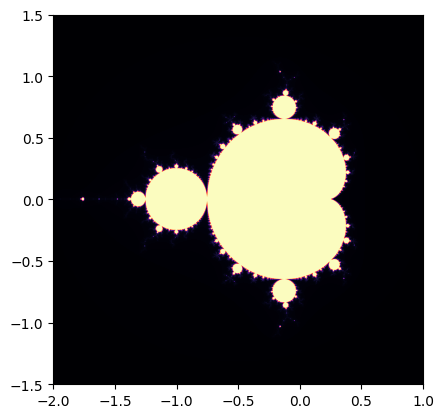

In [5]:
# set range for calculating mandelbrot
real = np.linspace (-2,1,5000)
imaginary = np.linspace (-1.5,1.5,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=500).T

plt.imshow(mandelbrot, extent = [-2,1,-1.5,1.5], cmap='magma')
plt.savefig("Fractal.png",dpi= 5000)
plt.show()

### Animation

current frame: 0
current frame: 0
current frame: 0
current frame: 0


KeyboardInterrupt: 

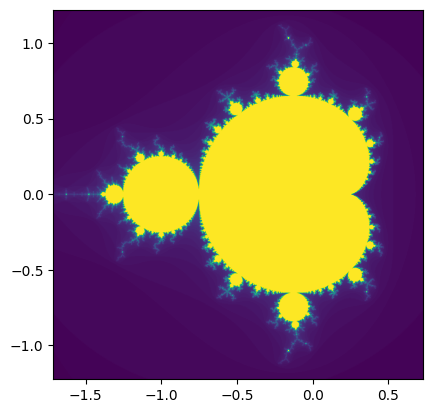

In [78]:
# initialize range to calculate
real_values = np.linspace(-2, 1, 1500)
imaginary_values = np.linspace(-1.5, 1.5, 1500)

# run and plot mandelbrot algorithm
mandelbrot = mandelbrot_set(real_values, imaginary_values)

fig, ax = plt.subplots()
im = ax.imshow(mandelbrot.T, extent=[-2, 1, -1.5, 1.5], animated=True)

# Create animation
ani = FuncAnimation(fig, update, frames=500, blit=True)
ani.save('mandel_zoomnew.gif', writer='pillow', fps=30)
plt.show()


### Random Monte Carlo sampling 

In [8]:
real_values = np.linspace(-2, 1, 10000)
imaginary_values = np.linspace(-1.5, 1.5, 1000)

mandel_ours = mandelbrot_set(real_values, imaginary_values, max_iter=1500)
A_m_ours = monte_carlo(25_000_000, mandel_ours)

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set (theory) is {A_m_theory:.4f}")
print(f"The area of the Mandelbrot set according to our montecarlo (s=10m, i= 1000) is {A_m_ours:.4f}")


The area of the Mandelbrot set (theory) is 1.5065
The area of the Mandelbrot set according to our montecarlo (s=10m, i= 1000) is 1.5093


In [9]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points

# Initialize the areas array to be of shape (len(iterations), len(samples))
areas = np.zeros((len(iterations), len(samples)))

real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)


for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(monte_carlo(s, mandelbrot_array) - A_m_theory) / 15
            areas[i, j] += area_dx

Current iteration is 10
Current iteration is 62
Current iteration is 114
Current iteration is 166
Current iteration is 218
Current iteration is 270
Current iteration is 322
Current iteration is 374
Current iteration is 426
Current iteration is 478
Current iteration is 531
Current iteration is 583
Current iteration is 635
Current iteration is 687
Current iteration is 739
Current iteration is 791
Current iteration is 843
Current iteration is 895
Current iteration is 947
Current iteration is 1000


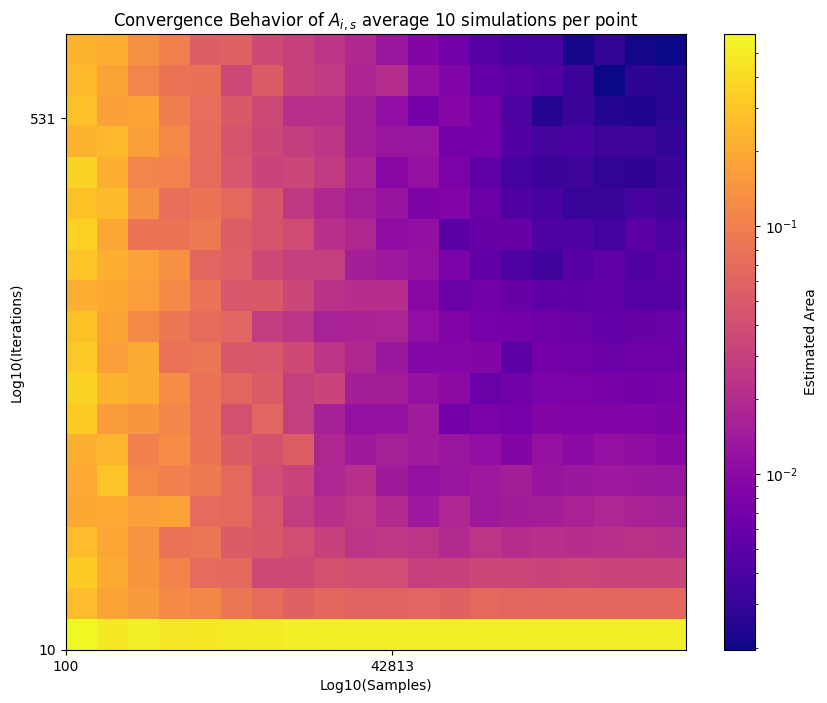

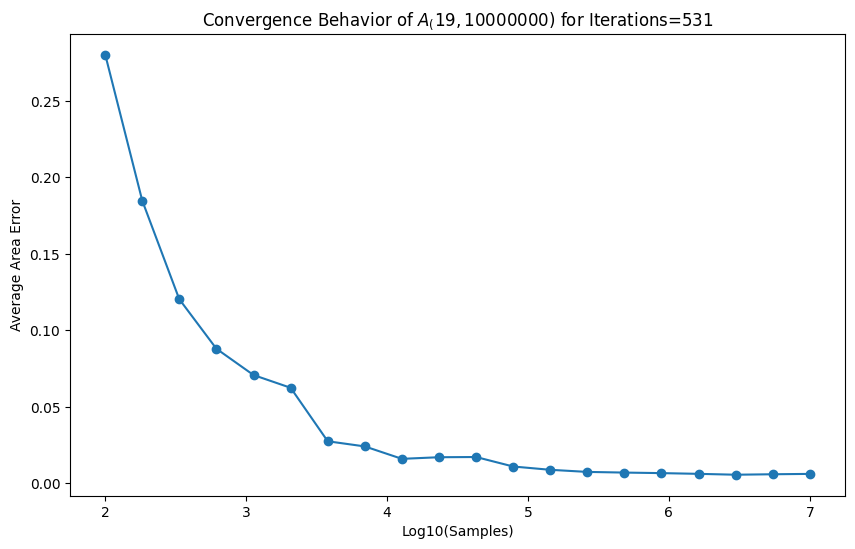

In [10]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
c = plt.imshow(areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[np.log10(samples[0]), np.log10(samples[-1]), np.log10(iterations[0]), np.log10(iterations[-1])])


plt.colorbar(label='Estimated Area')

plt.xlabel('Log10(Samples)')
plt.ylabel('Log10(Iterations)')


plt.xticks(np.log10(samples)[::10], samples[::10])
plt.yticks(np.log10(iterations)[::10], iterations[::10])

plt.title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')
plt.show()

# Additional Line plot for specific value of i
fixed_i_index = 10
plt.figure(figsize=(10, 6))
# plt.plot(np.log10(samples), areas[fixed_i_index, :], '-o')
plt.semilogx(samples, areas[fixed_i_index, :], '-o')
plt.xlabel('Log10(Samples)')
plt.ylabel('Average Area Error')
plt.title(f'Convergence Behavior of $A_{i,s}$ for Iterations={iterations[fixed_i_index]}')
plt.show()


### naam van area invullen lol

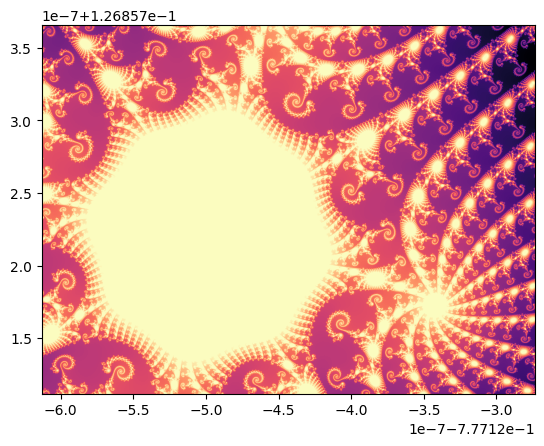

In [6]:
real = np.linspace (-0.777120613150274923773,-0.777120273471042550002,5000)
imaginary = np.linspace (0.126857111509958518545,0.126857366062765260933,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=1000).T

plt.imshow(mandelbrot, extent = [-0.777120613150274923773,-0.777120273471042550002,0.126857111509958518545,0.126857366062765260933], cmap='magma')
plt.savefig("Fractal_zoom.png",dpi= 5000)
plt.show()

### andere naam van area

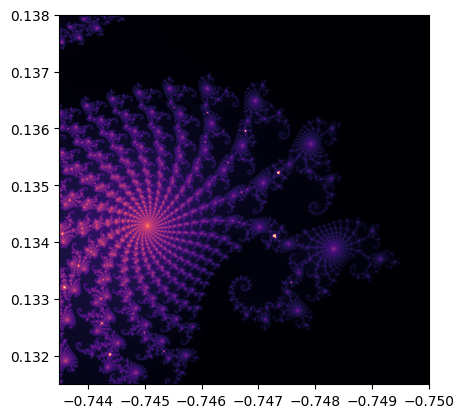

In [5]:
# elephant valley
real = np.linspace (-0.7435,-0.75,5000)
imaginary = np.linspace (0.1315,0.138,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=1000).T

plt.imshow(mandelbrot, extent = [-0.7435,-0.75,0.1315,0.138], cmap='magma')
plt.savefig("Fractal_zoom.png",dpi= 5000)
plt.show()